In [100]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D

In [68]:
#Part 1
#Read all the datasets
movie= pd.read_table("title.principals.tsv")
name_basic=pd.read_table("name.basics.tsv")
rating=pd.read_table('title.ratings.tsv')
title_basic=pd.read_table("title.basics.tsv")

In [69]:
#Subset ones that are movies
title_basic=title_basic.loc[title_basic["titleType"].str.contains("movie")]

In [70]:
#keep only movies that have actors and actress
movie= movie[movie['category'].str.contains("actor|actress")]

In [71]:
#keep only actors/actresses that are alive
name_basic=name_basic[name_basic['deathYear'].str.contains("\\N")]

In [72]:
# merge title and rating so movies without ratings are deleted
title_rating=rating.merge(title_basic)

In [73]:
# merge with names so we can have the actors/actresses' names
movie_name=movie.merge(name_basic)

In [74]:
# merge with title and rating 
movie_final=movie_name.merge(title_rating)

In [75]:
# delete movies that are too old, and movie actors/actresses that are before 1950
movie_final.startYear = movie_final.startYear.convert_objects(convert_numeric=True)
movie_final=movie_final.loc[movie_final['startYear'] >= 1959]
movie_final.birthYear = movie_final.birthYear.convert_objects(convert_numeric=True)
movie_final=movie_final.loc[movie_final['birthYear'] >= 1950]
#convert runtimeMinutes to numerical
movie_final.runtimeMinutes=movie_final.runtimeMinutes.convert_objects(convert_numeric=True)

C:\Users\lucas\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
C:\Users\lucas\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  after removing the cwd from sys.path.
C:\Users\lucas\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  import sys


In [76]:
# delete movies that are not that popular
movie_final=movie_final.loc[movie_final['numVotes'] >= 500]

In [77]:
# delete movies that don't have high ratings
movie_final=movie_final.loc[movie_final['averageRating'] >= 7]

In [78]:
# keep only movies that have more than one person so they can potentially have relationships 
movie_final = movie_final[movie_final.duplicated(subset=['tconst'], keep=False)]

In [79]:
# check for duplicates 
movie_final=movie_final.drop_duplicates()

In [80]:
#reset the index
#delete unnecesaary columns
data=movie_final.reset_index().iloc[:,[1,3,7,-10,-1]]

In [81]:
#take a look at our final data without subsetting 
movie_final.info(50)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17091 entries, 2532 to 655126
Data columns (total 21 columns):
tconst               17091 non-null object
ordering             17091 non-null int64
nconst               17091 non-null object
category             17091 non-null object
job                  17091 non-null object
characters           17091 non-null object
primaryName          17091 non-null object
birthYear            17091 non-null float64
deathYear            17091 non-null object
primaryProfession    17089 non-null object
knownForTitles       17091 non-null object
averageRating        17091 non-null float64
numVotes             17091 non-null int64
titleType            17091 non-null object
primaryTitle         17091 non-null object
originalTitle        17091 non-null object
isAdult              17091 non-null int64
startYear            17091 non-null float64
endYear              17091 non-null object
runtimeMinutes       17025 non-null float64
genres               17091

In [82]:
#take a look at our final data with subsetting
#the data set has 17091 observations
display(data.head())
display(data.info())

,tconst,nconst,primaryName,averageRating,genres
0,tt0117394,nm0650495,Regina Orozco,7.3,"Crime,Drama,Romance"
1,tt0117394,nm0319843,Daniel Giménez Cacho,7.3,"Crime,Drama,Romance"
2,tt0117394,nm0792354,Sherlyn,7.3,"Crime,Drama,Romance"
3,tt0276863,nm0530365,Sergi López,7.3,"Comedy,Romance"
4,tt0276863,nm0297443,Mariola Fuentes,7.3,"Comedy,Romance"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17091 entries, 0 to 17090
Data columns (total 5 columns):
tconst           17091 non-null object
nconst           17091 non-null object
primaryName      17091 non-null object
averageRating    17091 non-null float64
genres           17091 non-null object
dtypes: float64(1), object(4)
memory usage: 667.7+ KB


None

In [83]:
#have a list of unique movie titles and actors/actresses
test=data[:]
title=sorted(list(set(test['tconst'])))
actor=list(set(test['primaryName']))

In [84]:
#create a networkx graph
#add nodes from all the uniqe nconst id 
G = nx.Graph() 
G.add_nodes_from(actor)

# create a dictionary of all the movies and actor/actress within that movie
# movie is key and its value is a list of moving rating and all the actor/actress

movie_actor_dict = {}

for i in title:
    movie_actor_dict[i]=[0]

for index, row in test.iterrows():
    movie_actor_dict[row['tconst']][0]=row['averageRating']
    
for index, row in test.iterrows():
    movie_actor_dict[row['tconst']].append(row['primaryName'])

# with every key, create egg for all the actor/actress 
# weight=1 + the movie rating divided by 10
for i in movie_actor_dict.keys():
    for j in movie_actor_dict[i]:
        for k in movie_actor_dict[i]:
            if j!=k and not isinstance(j,float) and not isinstance(k,float):
                if G.has_edge(j, k):
                    G[j][k]['weight'] = G[j][k]['weight']+1+(movie_actor_dict[i][0]/10)
                else:
                    G.add_edge(j, k, weight=1+(movie_actor_dict[i][0]/10))


In [85]:
#Page Rank
pr=nx.pagerank(G)

In [86]:
import operator
sortx=sorted(pr.items(),key=operator.itemgetter(1))

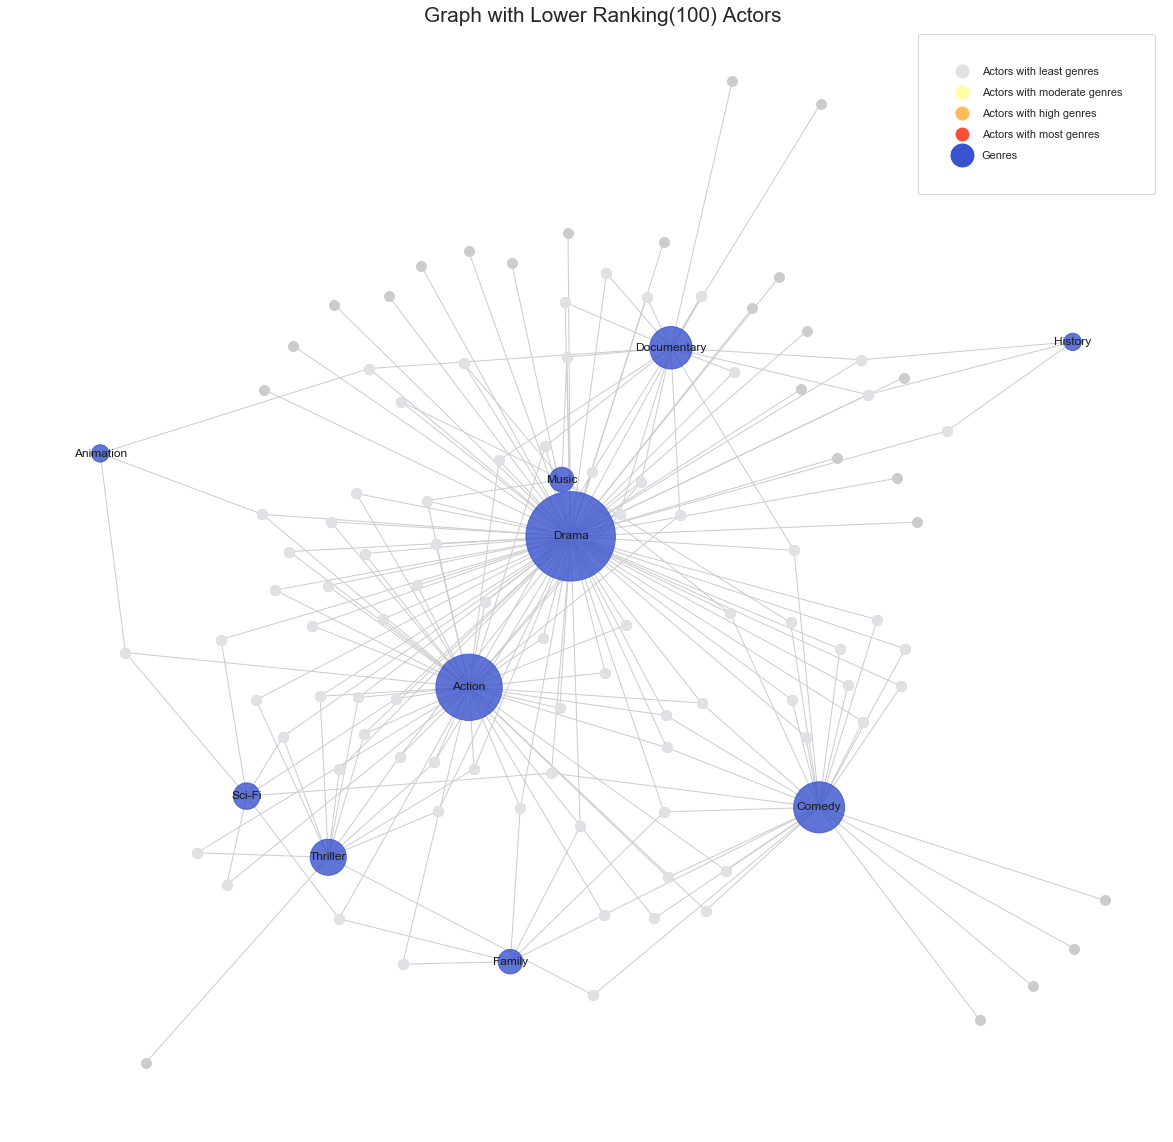

In [104]:
import numpy as np
from itertools import chain

# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split(',')))

# calculate lengths of splits
lens = test['genres'].str.split(',').map(len)

# create new dataframe, repeating or chaining as appropriate
res = pd.DataFrame({'tconst': np.repeat(test['tconst'], lens),
                    'nconst': np.repeat(test['nconst'], lens),
                    'primaryName': np.repeat(test['primaryName'], lens),
                    'averageRating': np.repeat(test['averageRating'], lens),
                    'genres': chainer(test['genres'])})
       
res.loc[res['genres'] == "Fantasy", 'genres'] = "Sci-Fi"
res.loc[res['genres'] == "Mystery", 'genres'] = "Sci-Fi"
res.loc[res['genres'] == "Horror", 'genres'] = "Thriller"
res.loc[res['genres'] == "Crime", 'genres'] = "Action"
res.loc[res['genres'] == "Biography", 'genres'] = "Documentary"
res.loc[res['genres'] == "Adventure", 'genres'] = "Action"
res.loc[res['genres'] == "Musical", 'genres'] = "Music"
res.loc[res['genres'] == "War", 'genres'] = "Action"
res.loc[res['genres'] == "Sport", 'genres'] = "Action"
res.loc[res['genres'] == "Romance", 'genres'] = "Drama"
res.loc[res['genres'] == "Western", 'genres'] = "Action"



sort1=sortx[:100]
actors=[x[0] for x in sort1]
resc=res.drop(res.index[:])
for i in actors:
    resc=resc.append (res[res['primaryName'].str.contains(i)])
genre=list(set(resc['genres']))



plt.figure(figsize=(20,20))
g = nx.from_pandas_edgelist(resc, source='primaryName', target='genres')
layout=nx.spring_layout(g,iterations=50)
#nx.draw_networkx_edges(g, layout, edge_color='#AAAAAA')
title_size=[100*g.degree(genres)+1 for genres in genre]
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=genre, 
                       node_size=title_size, # a LIST of sizes, based on g.degree
                       node_color='#3952ce',
                      k=0.5,alpha=0.8)
nx.draw_networkx_nodes(g, layout, nodelist=actors, node_color='#cccccc', node_size=100)

people1 = [person for person in actors if g.degree(person) >1 and g.degree(person) <4]
people2 = [person for person in actors if g.degree(person) >3 and g.degree(person) <7]
people3 = [person for person in actors if g.degree(person) >7 and g.degree(person) <10]
people4 = [person for person in actors if g.degree(person) >=10]

people=people3+people4


nx.draw_networkx_nodes(g, layout, nodelist=people1, node_color='#e0e1e5', node_size=100)
nx.draw_networkx_nodes(g, layout, nodelist=people2, node_color='#fcffa5', node_size=100)
nx.draw_networkx_nodes(g, layout, nodelist=people3, node_color='#fcba58', node_size=100)
nx.draw_networkx_nodes(g, layout, nodelist=people4, node_color='#fc4e37', node_size=100)



nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(genre, genre))
node_actor = dict(zip(people, people))


legend_elements = [Line2D([0], [0], marker='o', color='w', label='Actors with least genres', markerfacecolor='#e0e1e5', markersize=15),
                          Line2D([0], [0], marker='o', color='w', label='Actors with moderate genres',markerfacecolor='#fcffa5', markersize=15),
                          Line2D([0], [0], marker='o', color='w', label='Actors with high genres',markerfacecolor='#fcba58', markersize=15),
                          Line2D([0], [0], marker='o', color='w', label='Actors with most genres', markerfacecolor='#fc4e37', markersize=15),
                          Line2D([0], [0], marker='o', color='w', label='Genres', markerfacecolor='#3952ce', markersize=25)]

plt.legend(handles=legend_elements, loc='upper right',borderpad=3,labelspacing=1)


plt.axis('off')
nx.draw_networkx_labels(g, layout, labels=node_labels)
nx.draw_networkx_labels(g, layout, labels=node_actor)

plt.title("Graph with Lower Ranking(100) Actors",fontsize="xx-large")
plt.show()

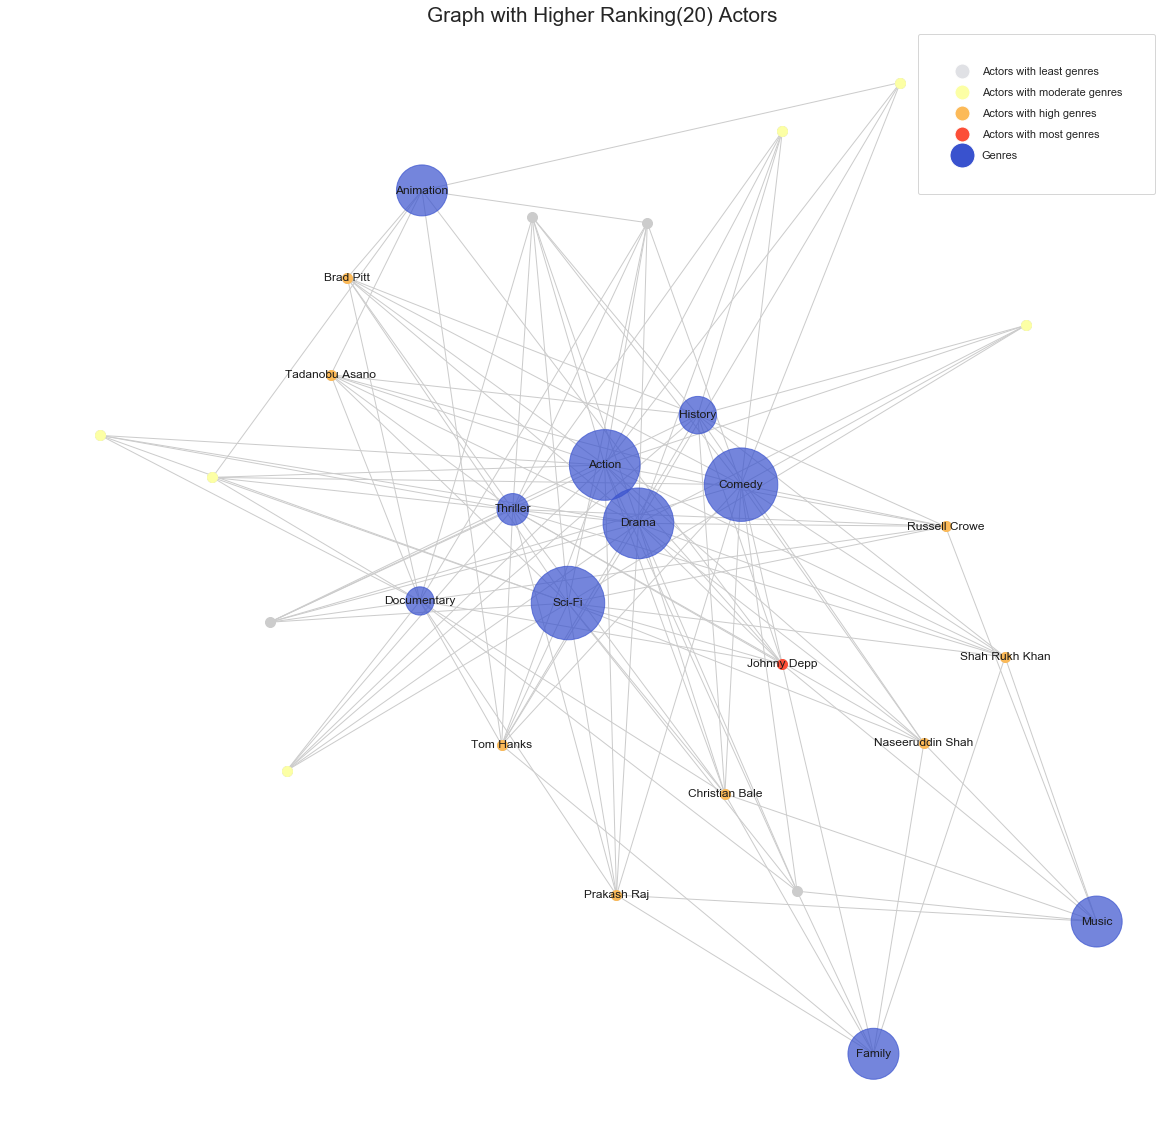

In [106]:
sort1=sortx[:-20:-1]
actors=[x[0] for x in sort1]
resc=res.drop(res.index[:])
for i in actors:
    resc=resc.append (res[res['primaryName'].str.contains(i)])
genre=list(set(resc['genres']))



plt.figure(figsize=(20,20))
g = nx.from_pandas_edgelist(resc, source='primaryName', target='genres')
layout=nx.spring_layout(g,iterations=50)
#used degree^10 to highlight the difference of occurance
title_size=[200*(g.degree(genres)^10)+1 for genres in genre]
nx.draw_networkx_nodes(g, layout,  nodelist=genre,  node_size=title_size,   node_color='#3952ce', alpha=0.7)
nx.draw_networkx_nodes(g, layout, nodelist=actors, node_color='#cccccc', node_size=100)

people1 = [person for person in actors if g.degree(person) >1 and g.degree(person) <4]
people2 = [person for person in actors if g.degree(person) >3 and g.degree(person) <7]
people3 = [person for person in actors if g.degree(person) >7 and g.degree(person) <10]
people4 = [person for person in actors if g.degree(person) >=10]

people=people3+people4


nx.draw_networkx_nodes(g, layout, nodelist=people1, node_color='#e0e1e5', node_size=100)
nx.draw_networkx_nodes(g, layout, nodelist=people2, node_color='#fcffa5', node_size=100)
nx.draw_networkx_nodes(g, layout, nodelist=people3, node_color='#fcba58', node_size=100)
nx.draw_networkx_nodes(g, layout, nodelist=people4, node_color='#fc4e37', node_size=100)


nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(genre, genre))
node_actor = dict(zip(people, people))


nx.draw_networkx_labels(g, layout, labels=node_labels)
nx.draw_networkx_labels(g, layout, labels=node_actor)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Actors with least genres', markerfacecolor='#e0e1e5', markersize=15),
                          Line2D([0], [0], marker='o', color='w', label='Actors with moderate genres',markerfacecolor='#fcffa5', markersize=15),
                          Line2D([0], [0], marker='o', color='w', label='Actors with high genres',markerfacecolor='#fcba58', markersize=15),
                          Line2D([0], [0], marker='o', color='w', label='Actors with most genres', markerfacecolor='#fc4e37', markersize=15),
                          Line2D([0], [0], marker='o', color='w', label='Genres', markerfacecolor='#3952ce', markersize=25)]

plt.legend(handles=legend_elements, loc='upper right',borderpad=3,labelspacing=1)
plt.title("Graph with Higher Ranking(20) Actors",fontsize="xx-large")

plt.axis('off')
plt.show()

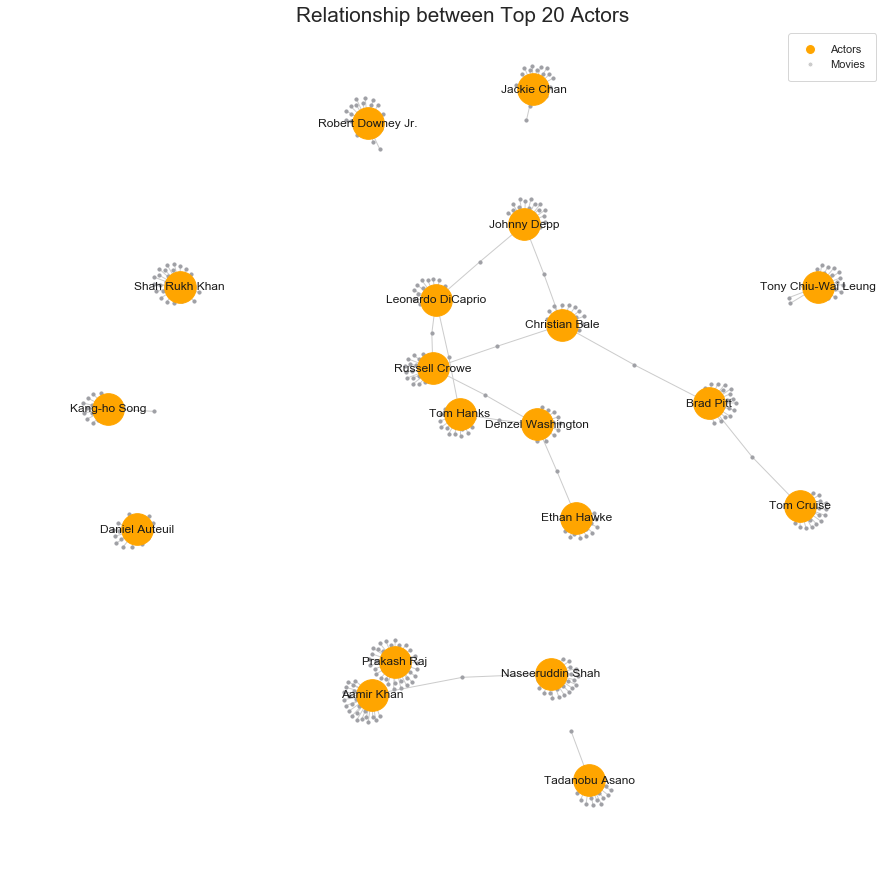

In [107]:
title=list(set(resc['tconst']))
actors=[x[0] for x in sort1]

plt.figure(figsize=(15,15))
g = nx.from_pandas_edgelist(resc, source='primaryName', target='tconst')
layout=nx.spring_layout(g,iterations=50)
nx.draw_networkx_nodes(g,   layout, nodelist=title,   node_size=10,node_color='#9fa0a5')

nx.draw_networkx_nodes(g, layout, nodelist=actors, node_color='orange', node_size=1000)

nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")
node_actor = dict(zip(actors, actors))
node_labels = dict(zip(title, title))
nx.draw_networkx_labels(g, layout, labels=node_actor)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Actors', markerfacecolor='orange', markersize=10),
                          Line2D([0], [0], marker='o', color='w', label='Movies',markerfacecolor='#cccccc', markersize=5)]

plt.legend(handles=legend_elements, loc='upper right',borderpad=1)
plt.title("Relationship between Top 20 Actors",fontsize="xx-large")
plt.axis('off')
plt.show()

In [90]:
#For graph purpose
graph_data=movie_final.reset_index().iloc[:,[-2,-4,-5,-9,-10]]

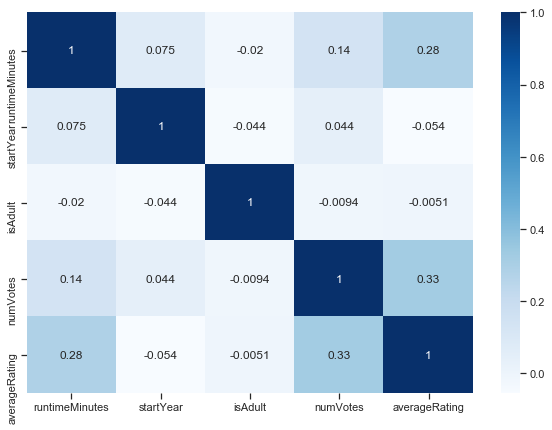

In [91]:
#Create a correlation plot of all the numerical values after data clean
plt.figure(figsize=(10, 7))
graph_data_corr = graph_data.corr()
sns.heatmap(graph_data_corr, 
            xticklabels = graph_data_corr.columns.values,
            yticklabels = graph_data_corr.columns.values,
            annot = True,cmap="Blues");

Text(0.5,0,'Number of Votes')

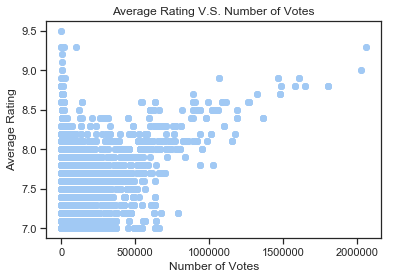

In [92]:
#Part 5 Exploration of Dataset 
#exploring relationship between average rating and num votes
plt.plot(movie_final['numVotes'],movie_final['averageRating'],'o')
plt.title('Average Rating V.S. Number of Votes')
plt.ylabel('Average Rating')
plt.xlabel('Number of Votes')

Text(0.5,0,'Start Year')

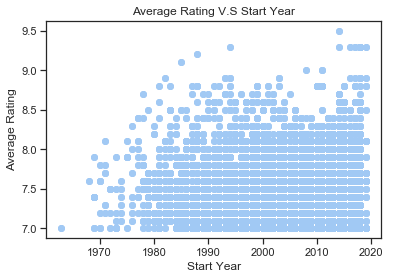

In [93]:
#People tend to give more generous ratings for new movie
plt.plot(movie_final['startYear'],movie_final['averageRating'],'o')
plt.title('Average Rating V.S Start Year')
plt.ylabel('Average Rating')
plt.xlabel('Start Year')

Text(0.5,0,'Movie Length in Minutes')

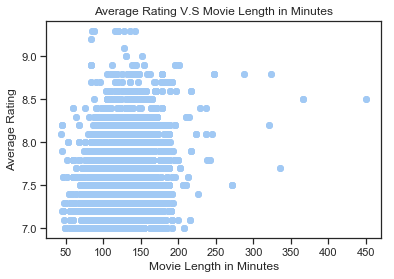

In [94]:
plt.plot(movie_final['runtimeMinutes'],movie_final['averageRating'],'o')
plt.title('Average Rating V.S Movie Length in Minutes')
plt.ylabel('Average Rating')
plt.xlabel('Movie Length in Minutes')

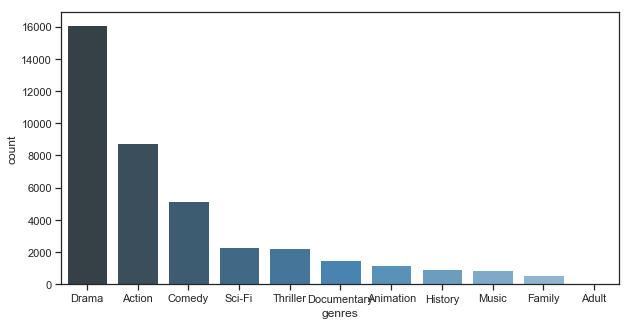

In [95]:
#count plot 
plt.figure(figsize=(10,5))
sns.countplot(res.genres, order=res.genres.value_counts().index,palette="Blues_d")

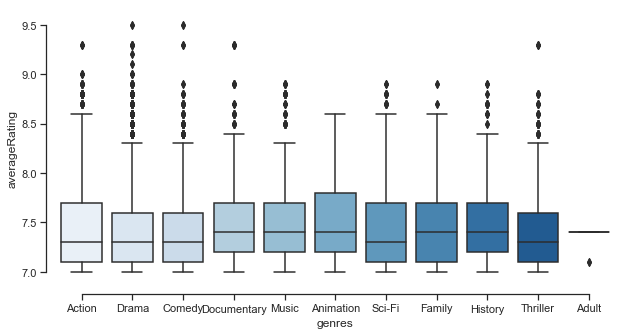

In [96]:
#Boxplot of average rating vs genres
plt.figure(figsize=(10,5))
sns.set(style="ticks", palette="pastel")
sns.boxplot(x="genres", y="averageRating",
            palette='Blues',
            data=res)
sns.despine(offset=10, trim=True)